In [1]:
import re
import requests
import json
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
import seaborn as sns

def getjson(url):
    response = requests.get(url)
    response = response.json()
    return response

In [2]:
vk_token = '***'


In [3]:
df = pd.DataFrame()
for offset in range(1, 1001):
    url = 'https://api.vk.com/method/wall.get?access_token=' + str(vk_token) + '&owner_id=-66669811&offset='+str(offset)+'&count=100&v=5.92'
    response = getjson(url)
    df_=pd.DataFrame(response['response']['items'])
    df = df.append(df_, ignore_index=True)
df.head()


,id,from_id,owner_id,date,marked_as_ads,post_type,text,attachments,post_source,comments,likes,reposts,views,is_favorite,copy_history
0,193057,-66669811,-66669811,1627045202,0,post,Все меньше дней остается до культового фестив...,"[{'type': 'photo', 'photo': {'album_id': -7, '...",{'type': 'api'},"{'count': 0, 'can_post': 1, 'groups_can_post':...","{'count': 7, 'user_likes': 0, 'can_like': 1, '...","{'count': 1, 'user_reposted': 0}",{'count': 7212},False,NaN
1,192312,-66669811,-66669811,1626972443,0,post,Skillbox и Bonnie & Slide запускают проект «По...,"[{'type': 'photo', 'photo': {'album_id': -7, '...",{'type': 'api'},"{'count': 14, 'can_post': 1, 'groups_can_post'...","{'count': 15, 'user_likes': 0, 'can_like': 1, ...","{'count': 6, 'user_reposted': 0}",{'count': 11703},False,NaN
2,192307,-66669811,-66669811,1626964721,0,post,"Помните, как рисовали в школе Лукоморье: леген...","[{'type': 'photo', 'photo': {'album_id': -7, '...",{'type': 'api'},"{'count': 4, 'can_post': 1, 'groups_can_post':...","{'count': 17, 'user_likes': 0, 'can_like': 1, ...","{'count': 20, 'user_reposted': 0}",{'count': 11997},False,NaN
3,192185,-66669811,-66669811,1626947165,0,post,"А вы знали, что наш мозг — настоящий трудоголи...","[{'type': 'photo', 'photo': {'album_id': -7, '...",{'type': 'api'},"{'count': 2, 'can_post': 1, 'groups_can_post':...","{'count': 41, 'user_likes': 0, 'can_like': 1, ...","{'count': 18, 'user_reposted': 0}",{'count': 13832},False,NaN
4,191890,-66669811,-66669811,1626880877,0,post,Может ли быть что-то горячее этого летнего сез...,"[{'type': 'photo', 'photo': {'album_id': -7, '...",{'type': 'api'},"{'count': 4, 'can_post': 1, 'groups_can_post':...","{'count': 18, 'user_likes': 0, 'can_like': 1, ...","{'count': 7, 'user_reposted': 0}",{'count': 13489},False,NaN


In [4]:
for column in ['attachments', 'post_source', 'comments', 'likes', 'reposts', 'views']:
    if column == 'attachments':
        df['attach_type'] = df['attachments'].apply(lambda x: x[0]['type'] if type(x) != float else x)
    else:
        for name in df.iloc[0][column].keys():
            df[column+'_'+name] = df[column].apply(lambda x: x[name])
    df.drop(columns=column, inplace=True)
    
df['date'] = df.date.apply(lambda x: datetime.fromisoformat((datetime.fromtimestamp(x) - timedelta(hours=0)).strftime('%Y-%m-%d %H:%M:%S')))


In [5]:
type_analisys = df.groupby('attach_type').agg({'id':'count', 'likes_count':'sum',
                               'comments_count':'sum', 'marked_as_ads':'sum',
                              'views_count':'sum'})
type_analisys

,id,likes_count,comments_count,marked_as_ads,views_count
attach_type,,,,,
album,214,6052,700,0,3672538
doc,823,89450,23437,0,15385620
link,24847,1493958,147731,0,510691172
photo,65199,6454315,835883,0,1660992349
podcast,9,657,45,0,163431
poll,53,1484,1007,0,865914
video,8782,891564,106853,0,217518732


In [6]:
type_analisys['relation'] = (type_analisys.likes_count / type_analisys.views_count)*100
type_analisys

,id,likes_count,comments_count,marked_as_ads,views_count,relation
attach_type,,,,,,
album,214,6052,700,0,3672538,0.164791
doc,823,89450,23437,0,15385620,0.581387
link,24847,1493958,147731,0,510691172,0.292536
photo,65199,6454315,835883,0,1660992349,0.388582
podcast,9,657,45,0,163431,0.402005
poll,53,1484,1007,0,865914,0.171380
video,8782,891564,106853,0,217518732,0.409879


In [7]:
df['month'] = df.date.apply(lambda x: x.month)
df['period'] = df.date.dt.to_period('M')
df['time'] = df.date.apply(lambda x: x.hour)
regex = re.compile('#\w+')
df['hashtags'] = df['text'].apply(lambda x: regex.findall(x))
df.head()

,id,from_id,owner_id,date,marked_as_ads,post_type,text,is_favorite,copy_history,attach_type,...,likes_user_likes,likes_can_like,likes_can_publish,reposts_count,reposts_user_reposted,views_count,month,period,time,hashtags
0,193057,-66669811,-66669811,2021-07-23 16:00:02,0,post,Все меньше дней остается до культового фестив...,False,NaN,photo,...,0,1,1,1,0,7212,7,2021-07,16,"[#OFFFMoscow, #Skillbox_OFFF]"
1,192312,-66669811,-66669811,2021-07-22 19:47:23,0,post,Skillbox и Bonnie & Slide запускают проект «По...,False,NaN,photo,...,0,1,1,6,0,11703,7,2021-07,19,[]
2,192307,-66669811,-66669811,2021-07-22 17:38:41,0,post,"Помните, как рисовали в школе Лукоморье: леген...",False,NaN,photo,...,0,1,1,20,0,11997,7,2021-07,17,[#откройсвоелукоморье]
3,192185,-66669811,-66669811,2021-07-22 12:46:05,0,post,"А вы знали, что наш мозг — настоящий трудоголи...",False,NaN,photo,...,0,1,1,18,0,13832,7,2021-07,12,[#Skillbox_задачки]
4,191890,-66669811,-66669811,2021-07-21 18:21:17,0,post,Может ли быть что-то горячее этого летнего сез...,False,NaN,photo,...,0,1,1,7,0,13489,7,2021-07,18,[#Skillbox_Untitled]


In [10]:
month_active = df.groupby('month').agg({'id':'count', 'likes_count':'sum',
                                        'comments_count':'sum', 'views_count':'sum'}).reset_index()
month_active['month'] = month_active.month.map({1: 'Январь', 2: 'Февраль', 3: 'Март', 4: 'Апрель',
                        5:'Май', 6:'Июнь', 7:'Июль', 8:'Август', 
                        9:'Сентябрь', 10:'Октябрь', 11: 'Ноябрь', 12: 'Декабрь'})
month_active

,month,id,likes_count,comments_count,views_count
0,Январь,9247,911329,95154,235633579
1,Февраль,11100,1067700,103200,255119900
2,Март,11900,904200,81600,244551500
3,Апрель,11600,940000,112400,258367400
4,Май,9600,918800,211000,238595600
5,Июнь,10572,679040,100961,228851594
6,Июль,7378,596936,71758,162319882
7,Август,5500,509300,46700,127914700
8,Сентябрь,5300,512100,59000,130111100
9,Октябрь,5500,709800,54700,168457100


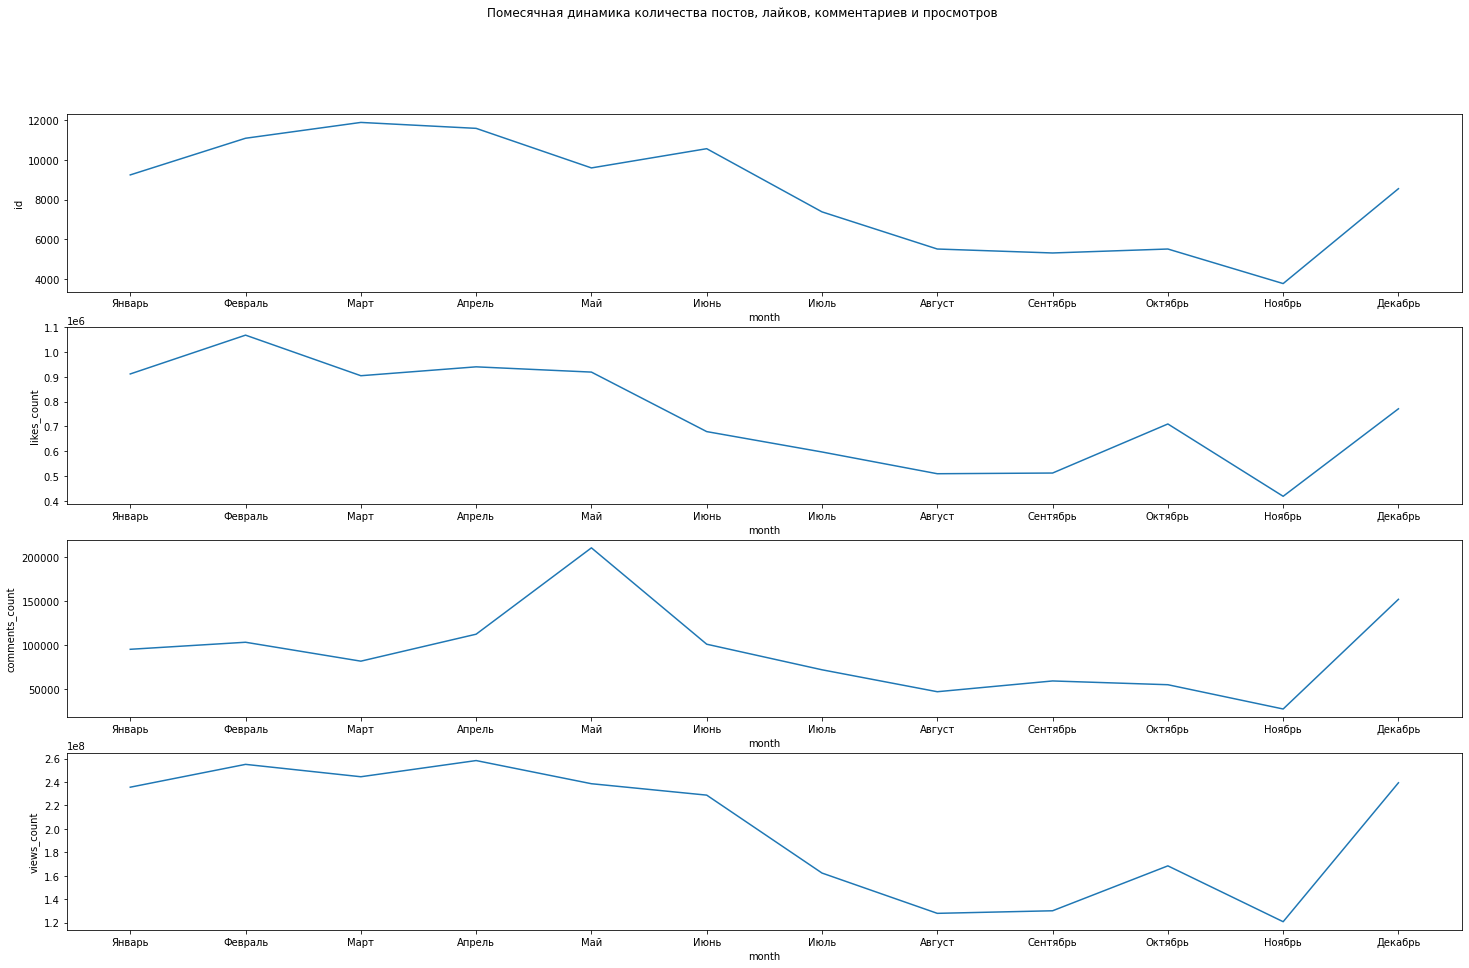

In [11]:
fig, ax = plt.subplots(nrows = 4, ncols =1, figsize=(25, 15))
fig.suptitle('Помесячная динамика количества постов, лайков, комментариев и просмотров')
for n, name in enumerate(['id', 'likes_count', 'comments_count', 'views_count']):
    sns.lineplot(data=month_active, x='month', y=name, ax=ax.ravel()[n])


In [12]:
year_active = df.groupby('period').agg({'id':'count', 'likes_count':'sum',
                                        'comments_count':'sum', 'views_count':'sum'}).reset_index()
year_active['period'] = [i.to_timestamp(freq='M') for i in year_active.period]
year_active

,period,id,likes_count,comments_count,views_count
0,2019-11-30,153,11729,1276,2417603
1,2019-12-31,2850,252451,46145,55789968
2,2020-01-31,4947,434829,51154,109171479
3,2020-02-29,5600,649100,46500,116395100
4,2020-03-31,5900,553200,53200,115141300
5,2020-04-30,5000,490100,67300,111974600
6,2020-05-31,3900,595100,166700,114256700
7,2020-06-30,5800,484900,84600,136862800
8,2020-07-31,6000,543500,65300,133183100
9,2020-08-31,5500,509300,46700,127914700


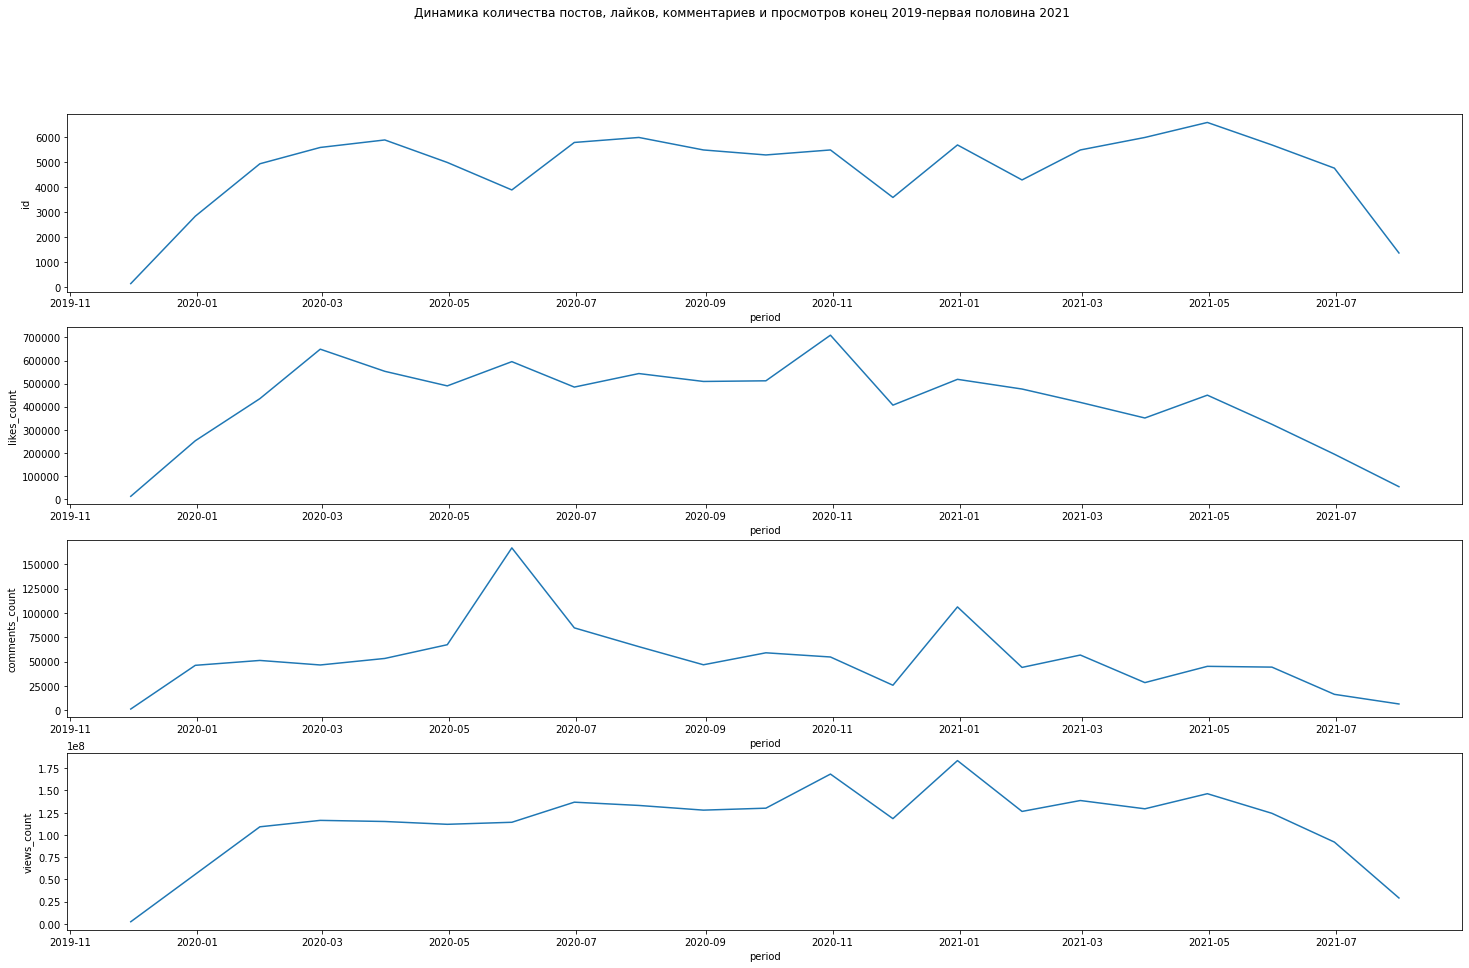

In [13]:
fig, ax = plt.subplots(nrows = 4, ncols =1, figsize=(25, 15))
fig.suptitle('Динамика количества постов, лайков, комментариев и просмотров конец 2019-первая половина 2021')
for n, name in enumerate(['id', 'likes_count', 'comments_count', 'views_count']):
    sns.lineplot(data=year_active, x='period', y=name, ax=ax.ravel()[n])

In [14]:
hour_active = df.groupby('time').agg({'id':'count', 'likes_count':'sum',
                                        'comments_count':'sum', 'views_count':'sum'}).reset_index()
hour_active

,time,id,likes_count,comments_count,views_count
0,8,9,657,45,163431
1,9,100,7700,1700,2502000
2,10,1433,131374,26768,35840373
3,11,11439,1449010,179252,298936673
4,12,12729,1563949,171285,347080776
5,13,10028,961316,138828,258057828
6,14,8019,784221,88108,204197180
7,15,8396,697123,68602,202363750
8,16,7300,630243,142067,176027492
9,17,8231,670456,65122,191146709


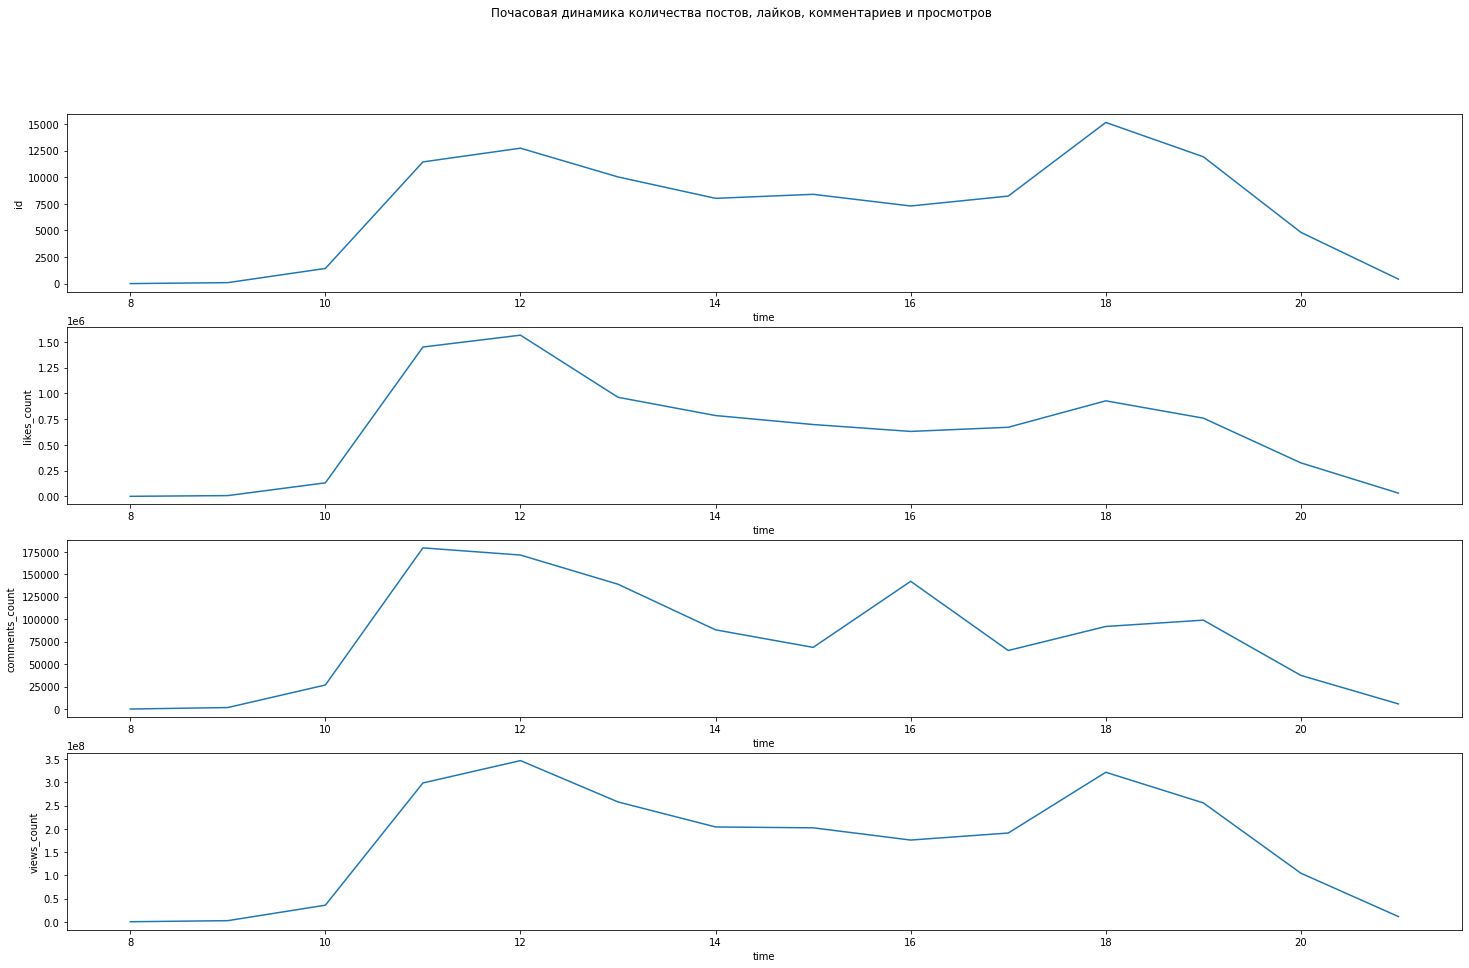

In [15]:
fig, ax = plt.subplots(nrows = 4, ncols =1, figsize=(25, 15))
fig.suptitle('Почасовая динамика количества постов, лайков, комментариев и просмотров')
for n, name in enumerate(['id', 'likes_count', 'comments_count', 'views_count']):
    sns.lineplot(data=hour_active, x='time', y=name, ax=ax.ravel()[n])

In [16]:
hashtags = df.explode('hashtags')
hashtags.drop_duplicates(subset=['hashtags', 'text'], inplace=True)
hashtags['hashtags'] = hashtags['hashtags'].apply(lambda x: x.lower() if type(x) != float else x)
hashtags

,id,from_id,owner_id,date,marked_as_ads,post_type,text,is_favorite,copy_history,attach_type,...,likes_user_likes,likes_can_like,likes_can_publish,reposts_count,reposts_user_reposted,views_count,month,period,time,hashtags
0,193057,-66669811,-66669811,2021-07-23 16:00:02,0,post,Все меньше дней остается до культового фестив...,False,NaN,photo,...,0,1,1,1,0,7212,7,2021-07,16,#offfmoscow
0,193057,-66669811,-66669811,2021-07-23 16:00:02,0,post,Все меньше дней остается до культового фестив...,False,NaN,photo,...,0,1,1,1,0,7212,7,2021-07,16,#skillbox_offf
1,192312,-66669811,-66669811,2021-07-22 19:47:23,0,post,Skillbox и Bonnie & Slide запускают проект «По...,False,NaN,photo,...,0,1,1,6,0,11703,7,2021-07,19,NaN
2,192307,-66669811,-66669811,2021-07-22 17:38:41,0,post,"Помните, как рисовали в школе Лукоморье: леген...",False,NaN,photo,...,0,1,1,20,0,11997,7,2021-07,17,#откройсвоелукоморье
3,192185,-66669811,-66669811,2021-07-22 12:46:05,0,post,"А вы знали, что наш мозг — настоящий трудоголи...",False,NaN,photo,...,0,1,1,18,0,13832,7,2021-07,12,#skillbox_задачки
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99799,41500,-66669811,-66669811,2019-11-25 12:11:14,0,post,На этой неделе смотрите вебинары по маркетингу...,False,NaN,photo,...,0,1,1,7,0,11288,11,2019-11,12,#расписание_skillbox
99899,41498,-66669811,-66669811,2019-11-24 19:00:02,0,post,Подборка шрифтов месяца! \n \n★ MC-Cutter. Экс...,False,NaN,photo,...,0,1,1,6,0,11169,11,2019-11,19,#шрифты_skillbox
99899,41498,-66669811,-66669811,2019-11-24 19:00:02,0,post,Подборка шрифтов месяца! \n \n★ MC-Cutter. Экс...,False,NaN,photo,...,0,1,1,6,0,11169,11,2019-11,19,#skillbox_дизайн
99999,41487,-66669811,-66669811,2019-11-23 11:00:02,0,post,Идеальный баланс креативности и юмора — это пр...,False,NaN,video,...,0,1,1,5,0,9210,11,2019-11,11,#skillbox_маркетинг


In [17]:
hashtags_analysis = hashtags.groupby('hashtags').agg({'id': 'count', 'likes_count': 'sum',
                                                      'comments_count':'sum', 'views_count':'sum'})
hashtags_analysis

,id,likes_count,comments_count,views_count
hashtags,,,,
#191970,1,192,4,35963
#3d_графика_skillbox,1,287,19,41493
#7fffd4,1,192,4,35963
#aic_skillbox,2,57,14,36511
#avocard,1,31,11,12341
...,...,...,...,...
#черная_пятница_skillbox,2,51,0,41932
#школа_будущего,1,57,11,27239
#шрифты_skillbox,10,790,95,216459


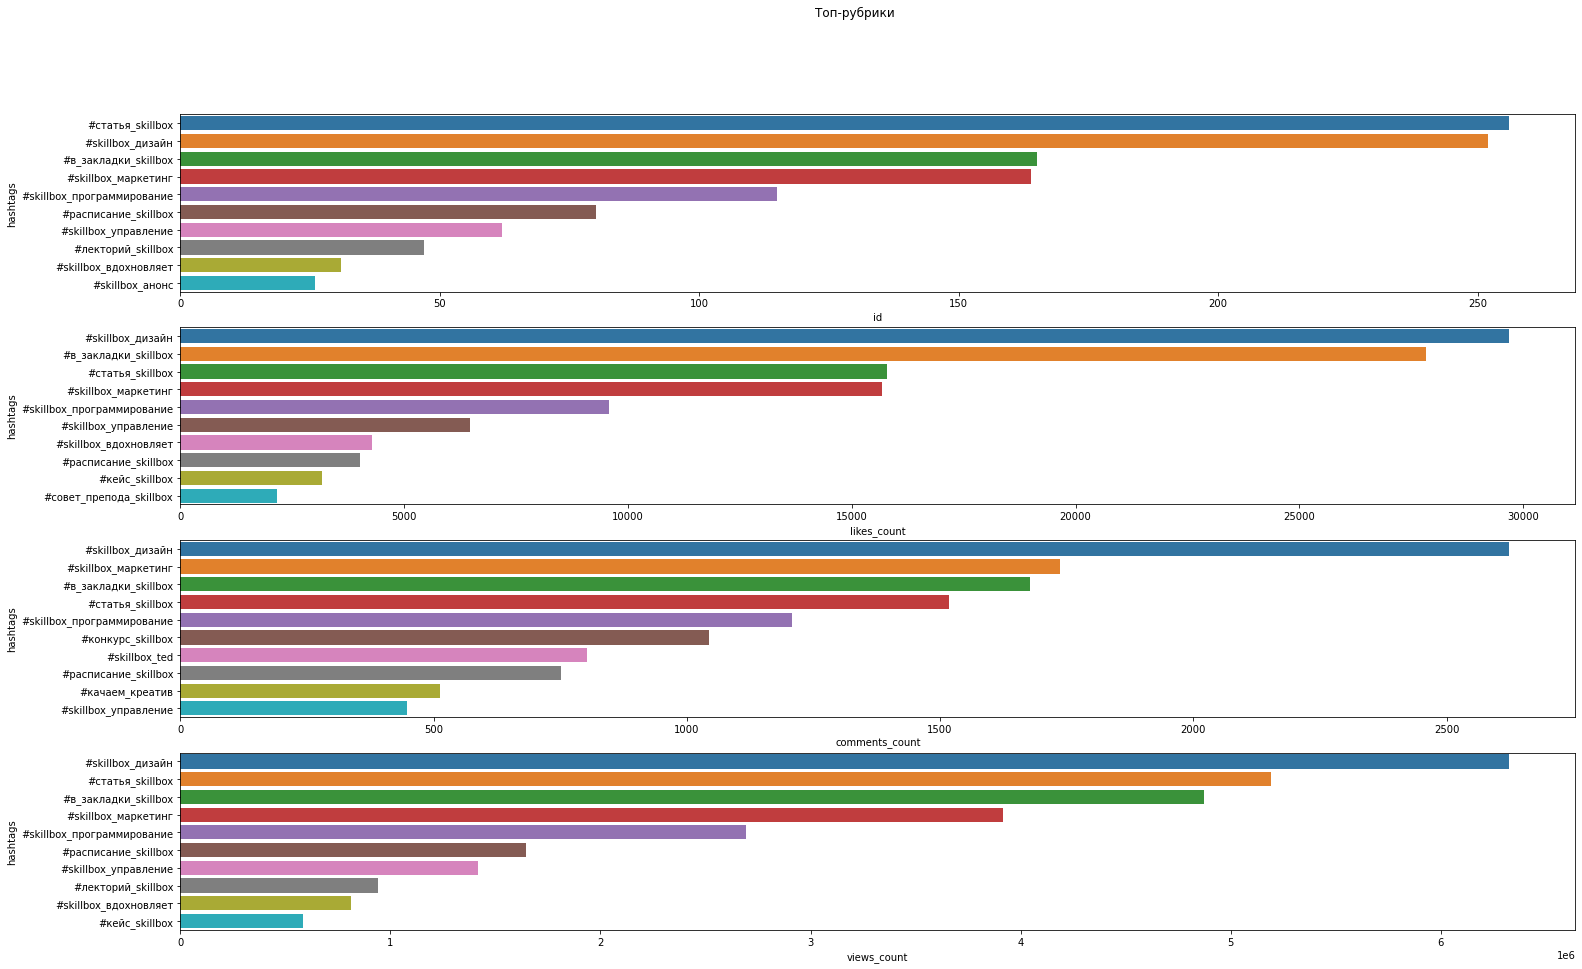

In [18]:
fig, ax = plt.subplots(nrows = 4, ncols =1, figsize=(25, 15))
fig.suptitle('Топ-рубрики')
for n, name in enumerate(['id', 'likes_count', 'comments_count', 'views_count']):
    h_df = hashtags_analysis.sort_values(name, ascending = False).reset_index().head(10)
    sns.barplot(data=h_df, x=name, y='hashtags', ax=ax.ravel()[n], orient='h')

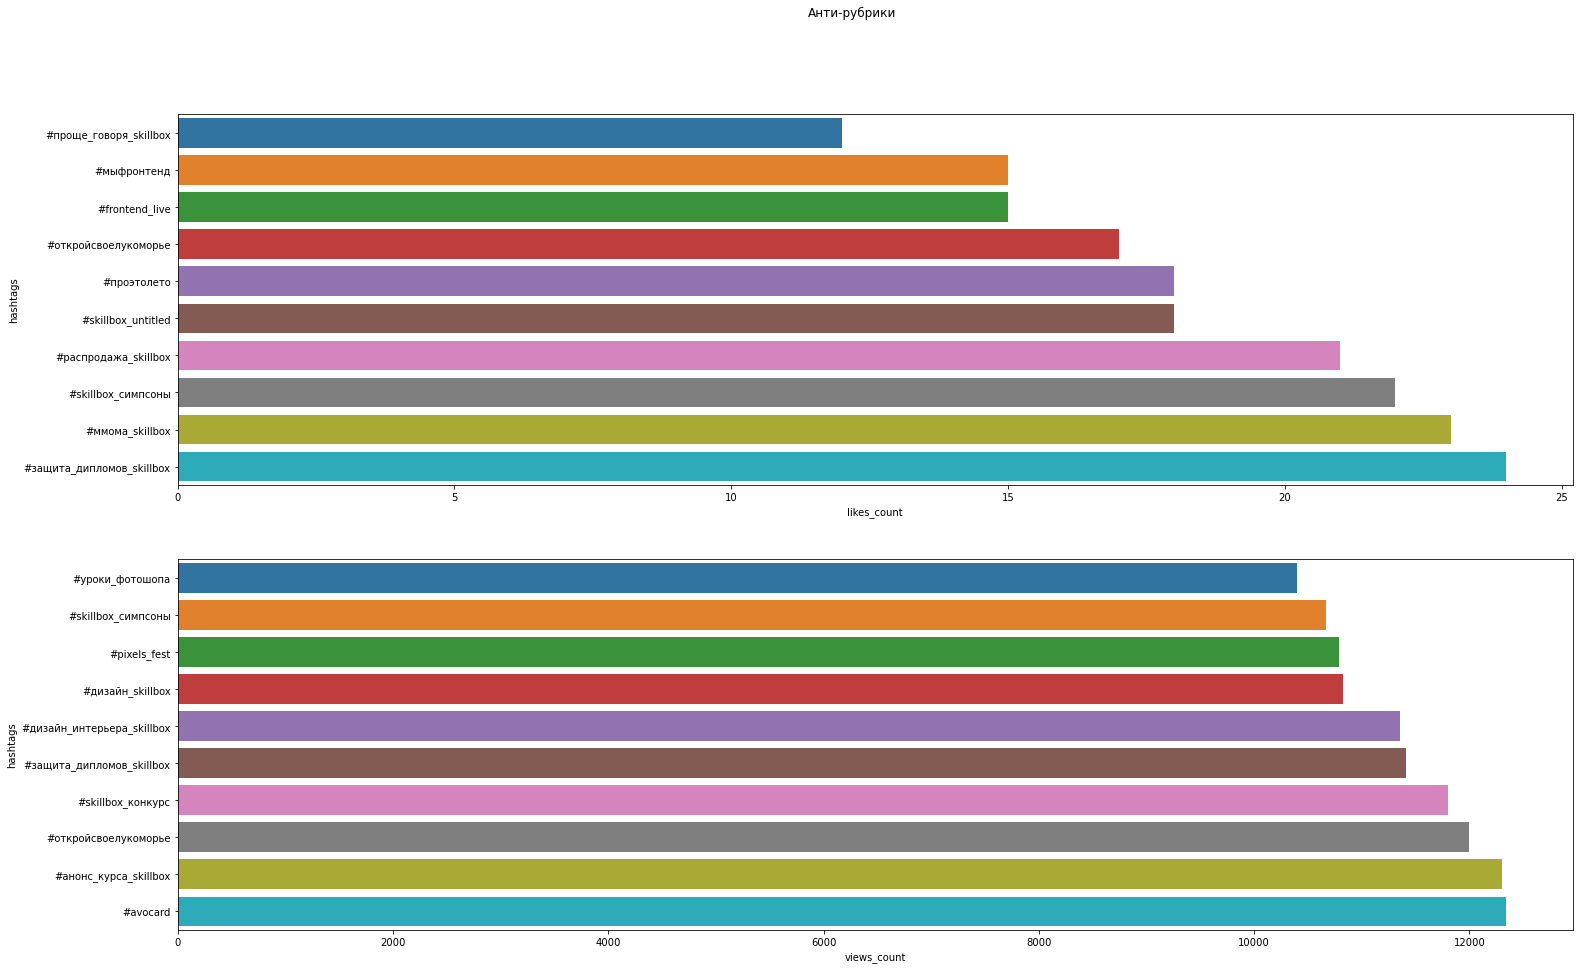

In [19]:
fig, ax = plt.subplots(nrows = 2, ncols =1, figsize=(25, 15))
fig.suptitle('Анти-рубрики')
for n, name in enumerate(['likes_count', 'views_count']):
    h_df = hashtags_analysis.sort_values(name).reset_index().head(10)
    sns.barplot(data=h_df, x=name, y='hashtags', ax=ax.ravel()[n], orient='h')

# Выводы #

Проведя анализ, следует сделать следующие выводы:

* Люди чаще всего реагируют на посты, в которых встречаются прикрепленные документы, видео и фотографии. Альбомы чаще всего игнорируются.
* Подтверждаем, что лайки и комментарии напрямую зависят от количества просмотров
* Наиболее активны люди в первой половине дня (10-12 часов) и в конце рабочего дня (17-19 часов, в частности 18), поэтому следует выкладывать посты в это время.
* Наиболее интересные рубрики - это те, которые имеют прикладное значение - #В_закладки_SkillBox, #статья_skillbox
* Неудачными оказались разделы #уроки_фотошопы, #skillbox_untitle